# UNesT Brain Segmentation Inference

In [1]:
import sys
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../UNesT/wholebrainSeg') 
from networks.unest import UNesT 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/home/orion23/Documents/repos/neurocut-tms-navigation-segmentation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/orion23/Documents/repos/neurocut-tms-navigation-segmentation/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Pretrained Weights

In [2]:
checkpoint_path = '../checkpoints/pretrain_model.pt' 

model = UNesT(
    in_channels=1,
    out_channels=133,
    img_size=(96, 96, 96),  
    feature_size=16,         
    patch_size=4,
    depths=(2, 2, 8),
    num_heads=(4, 8, 16),
    embed_dim=(128, 256, 512),
    window_size=(7, 7, 7),
    norm_name="instance",
    conv_block=False,
    res_block=True,
    dropout_rate=0.0
).to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'])
model.eval()


UNesT(
  (nestViT): NestTransformer3D(
    (patch_embed): PatchEmbed3D(
      (proj): Conv3d(1, 128, kernel_size=(4, 4, 4), stride=(4, 4, 4))
    )
    (levels): ModuleList(
      (0): NestLevel(
        (pool): Identity()
        (transformer_encoder): Sequential(
          (0): TransformerLayer(
            (norm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU(approximate='none')
              (drop1): Dropout(p=0.0, inplace=False)
          

## Data

In [4]:
input_img_path = '../data/preprocessed/IBSR_10_zscore.nii.gz'
img_nii = nib.load(input_img_path)
img = img_nii.get_fdata().astype(np.float32)
img = np.squeeze(img) 

target_shape = (96, 96, 96)
# Crop or pad to target shape
# def crop_or_pad(img, target_shape):
#     result = np.zeros(target_shape, dtype=img.dtype)
#     min_shape = tuple(min(s, t) for s, t in zip(img.shape, target_shape))
#     slices_src = tuple(slice(0, ms) for ms in min_shape)
#     slices_dst = tuple(slice(0, ms) for ms in min_shape)
#     result[slices_dst] = img[slices_src]
#     return result

def crop_or_pad_center(img, target_shape):
    img_shape = img.shape
    result = np.zeros(target_shape, dtype=img.dtype)
    src_slices = []
    tgt_slices = []
    for i in range(3):
        src = img_shape[i]
        tgt = target_shape[i]
        if src >= tgt:
            start_src = (src - tgt) // 2
            end_src = start_src + tgt
            start_tgt = 0
            end_tgt = tgt
        else:
            start_src = 0
            end_src = src
            start_tgt = (tgt - src) // 2
            end_tgt = start_tgt + src
        src_slices.append(slice(start_src, end_src))
        tgt_slices.append(slice(start_tgt, end_tgt))
    result[tuple(tgt_slices)] = img[tuple(src_slices)]
    return result

img = crop_or_pad_center(img, target_shape)

img = (img - img.mean()) / (img.std() + 1e-8)

img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)
print('Final tensor shape:', img_tensor.shape)


Final tensor shape: torch.Size([1, 1, 96, 96, 96])


## Inference

In [5]:
with torch.no_grad():
    output = model(img_tensor)
    pred = torch.argmax(output, dim=1).cpu().numpy()[0]


[DEBUG] blockify: D=24, H=24, W=24, block_size=6
[DEBUG] blockify: D=12, H=12, W=12, block_size=6
[DEBUG] blockify: D=6, H=6, W=6, block_size=6


## Segmentation Result to NIfTI

In [6]:
out_nii = nib.Nifti1Image(pred.astype(np.uint8), img_nii.affine, img_nii.header)
out_path = '../results/segmentation.nii.gz' 
nib.save(out_nii, out_path)
print(f'Saved segmentation to {out_path}')


Saved segmentation to ../results/segmentation.nii.gz


## Visualization

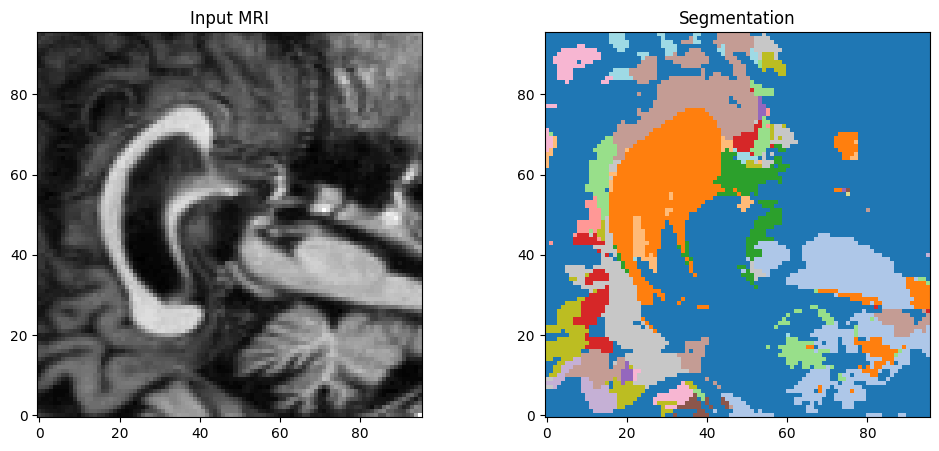

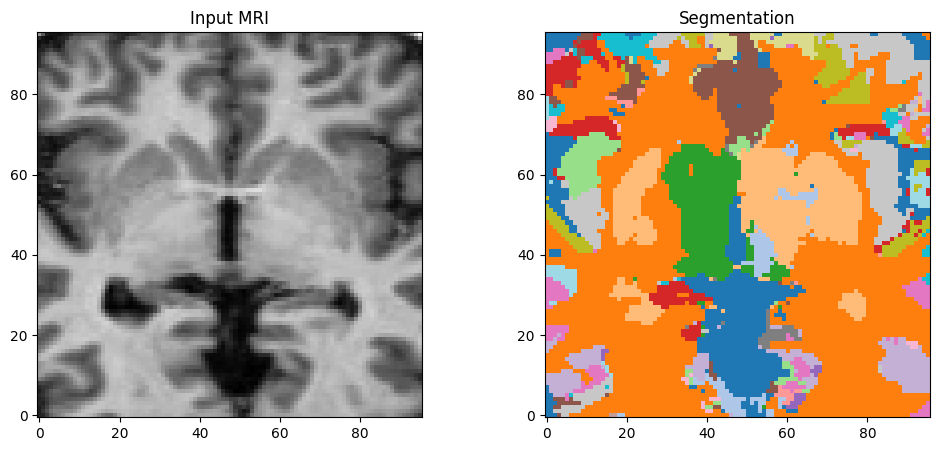

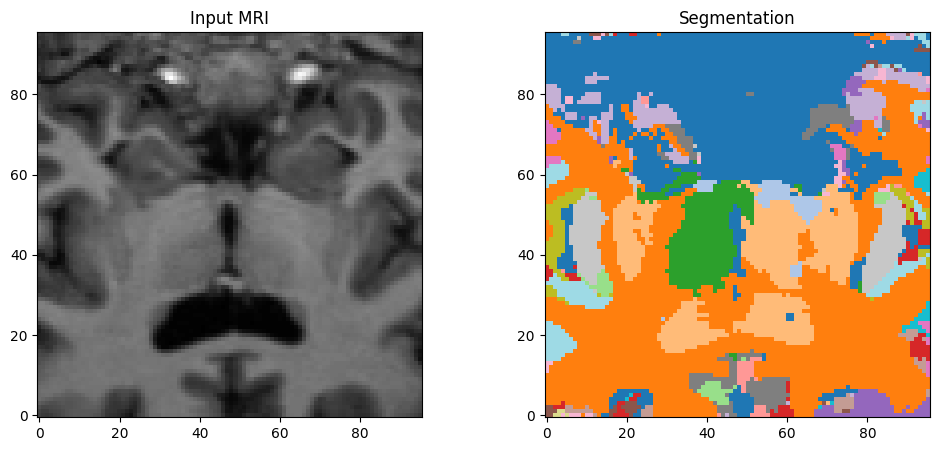

In [7]:
def show_slices(img, seg, axis=0):
    mid = img.shape[axis] // 2
    if axis == 0:
        img_slice = img[mid, :, :]
        seg_slice = seg[mid, :, :]
    elif axis == 1:
        img_slice = img[:, mid, :]
        seg_slice = seg[:, mid, :]
    else:
        img_slice = img[:, :, mid]
        seg_slice = seg[:, :, mid]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_slice.T, cmap='gray', origin='lower')
    plt.title('Input MRI')
    plt.subplot(1, 2, 2)
    plt.imshow(seg_slice.T, cmap='tab20', origin='lower')
    plt.title('Segmentation')
    plt.show()

show_slices(img, pred, axis=0)  # axial
show_slices(img, pred, axis=1)  # coronal
show_slices(img, pred, axis=2)  # sagittal
